# Big Data Processing

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Step 1: Spark Session with memory-safe config
spark = SparkSession.builder \
    .appName("FraudDetectionModel") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.kryoserializer.buffer", "512m") \
    .config("spark.kryoserializer.buffer.max", "1g") \
    .getOrCreate()

# Step 2: Load Data
df = spark.read.csv("/Users/anand/Downloads/transactions_train1.csv", header=True, inferSchema=True)

# Step 3: Drop problematic columns
df = df.drop("nameOrig", "nameDest")

# Step 4: Feature Engineering
df = df.withColumn("balanceOrigDiff", col("oldbalanceOrig") - col("newbalanceOrig"))
df = df.withColumn("balanceDestDiff", col("newbalanceDest") - col("oldbalanceDest"))

# Step 5: Index categorical column 'type'
type_indexer = StringIndexer(inputCol="type", outputCol="type_index")

# Step 6: Select features (safe subset)
feature_cols = [
    "type_index", "amount", "oldbalanceOrig", "newbalanceOrig",
    "oldbalanceDest", "newbalanceDest", "balanceOrigDiff", "balanceDestDiff"
]

# Step 7: Assemble and scale features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vec")
scaler = StandardScaler(inputCol="features_vec", outputCol="features")

# Step 8: Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="isFraud", numTrees=20)

# Step 9: Build pipeline
pipeline = Pipeline(stages=[type_indexer, assembler, scaler, rf])

# Step 10: Optional sampling to reduce load while testing
# df = df.sample(withReplacement=False, fraction=0.3, seed=42)

# Step 11: Train-test split
train, test = df.randomSplit([0.7, 0.3], seed=42)

# Step 12: Train model
model = pipeline.fit(train)

# Step 13: Predict and evaluate
predictions = model.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="isFraud")
auc = evaluator.evaluate(predictions)

print(f"AUC-ROC: {auc:.4f}")

AUC-ROC: 0.9929


# Exploratory Data Analysis (EDA)

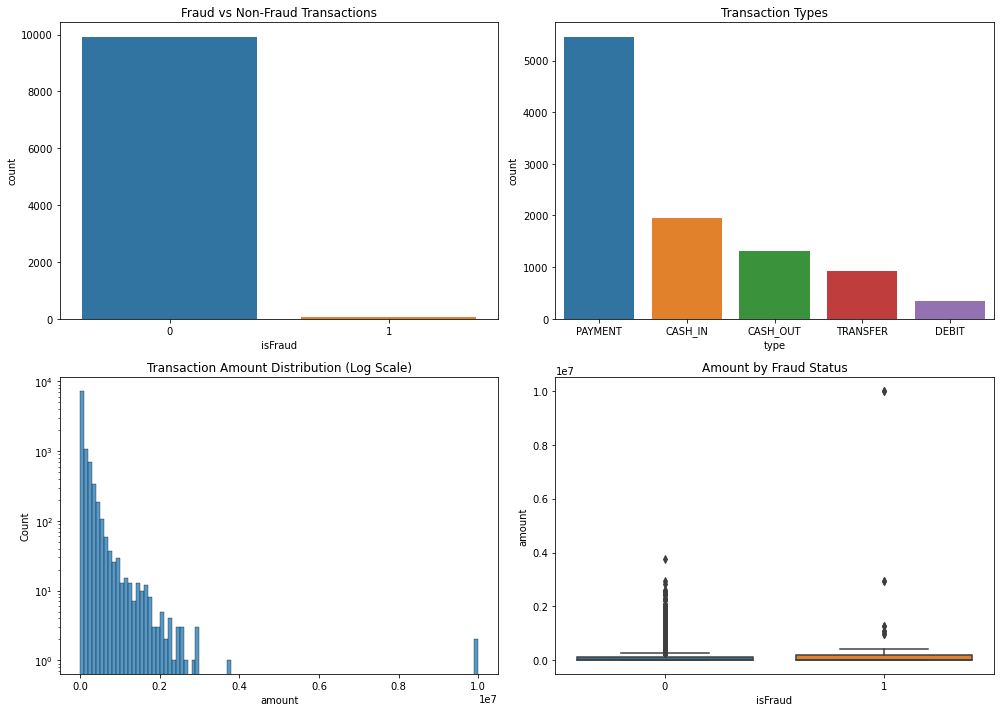

{'shape': (10000, 10),
 'columns': ['step',
  'type',
  'amount',
  'nameOrig',
  'oldbalanceOrig',
  'newbalanceOrig',
  'nameDest',
  'oldbalanceDest',
  'newbalanceDest',
  'isFraud'],
 'null_values': step              0
 type              0
 amount            0
 nameOrig          0
 oldbalanceOrig    0
 newbalanceOrig    0
 nameDest          0
 oldbalanceDest    0
 newbalanceDest    0
 isFraud           0
 dtype: int64,
 'dtypes': step                int64
 type               object
 amount            float64
 nameOrig           object
 oldbalanceOrig    float64
 newbalanceOrig    float64
 nameDest           object
 oldbalanceDest    float64
 newbalanceDest    float64
 isFraud             int64
 dtype: object,
 'fraud_distribution': 0    0.9932
 1    0.0068
 Name: isFraud, dtype: float64,
 'transaction_types': PAYMENT     5465
 CASH_IN     1949
 CASH_OUT    1321
 TRANSFER     921
 DEBIT        344
 Name: type, dtype: int64}

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load data again in pandas for EDA
df = pd.read_csv("/Users/anand/Downloads/transactions_train1.csv")

# Basic EDA
eda_summary = {
    "shape": df.shape,
    "columns": df.columns.tolist(),
    "null_values": df.isnull().sum(),
    "dtypes": df.dtypes,
    "fraud_distribution": df['isFraud'].value_counts(normalize=True),
    "transaction_types": df['type'].value_counts()
}

# Plotting distributions
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Fraud vs Non-Fraud
sns.countplot(data=df, x='isFraud', ax=axs[0, 0])
axs[0, 0].set_title("Fraud vs Non-Fraud Transactions")

# Transaction types
sns.countplot(data=df, x='type', order=df['type'].value_counts().index, ax=axs[0, 1])
axs[0, 1].set_title("Transaction Types")

# Amount distribution (log scale)
sns.histplot(df['amount'], bins=100, ax=axs[1, 0], log_scale=(False, True))
axs[1, 0].set_title("Transaction Amount Distribution (Log Scale)")

# Amount by fraud status
sns.boxplot(data=df, x='isFraud', y='amount', ax=axs[1, 1])
axs[1, 1].set_title("Amount by Fraud Status")

plt.tight_layout()
plt.show()

eda_summary


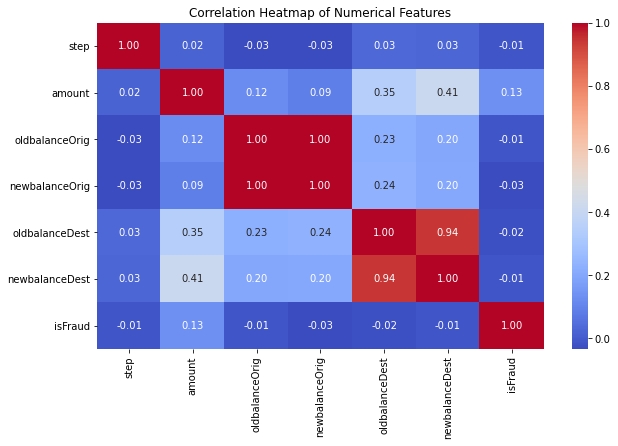

In [8]:
# Correlation heatmap (excluding categorical and identifier columns)
numeric_df = df.drop(columns=['type', 'nameOrig', 'nameDest'])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

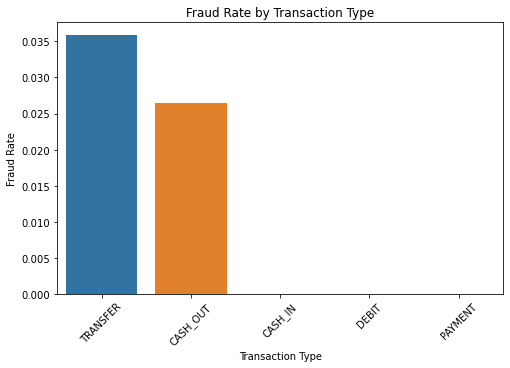

In [9]:
# Fraud rate by transaction type
fraud_by_type = df.groupby("type")["isFraud"].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values)
plt.title("Fraud Rate by Transaction Type")
plt.ylabel("Fraud Rate")
plt.xlabel("Transaction Type")
plt.xticks(rotation=45)
plt.show()

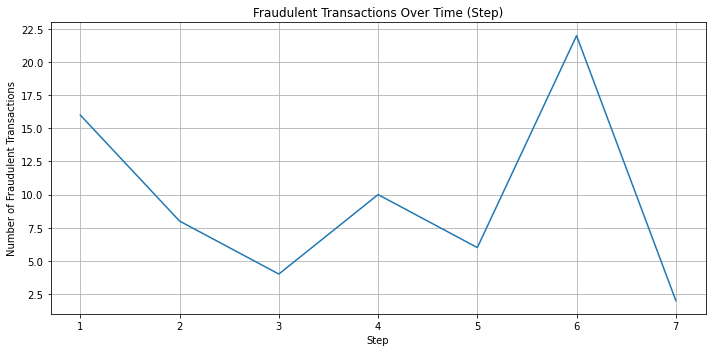

In [10]:
# Fraud count over time (step)
fraud_by_step = df[df["isFraud"] == 1].groupby("step").size()

plt.figure(figsize=(10, 5))
fraud_by_step.plot(kind='line')
plt.title("Fraudulent Transactions Over Time (Step)")
plt.xlabel("Step")
plt.ylabel("Number of Fraudulent Transactions")
plt.grid(True)
plt.tight_layout()
plt.show()